## Analyze TriOS Data

Uncertainty, comparing to TSG, and 

In [1]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/ivan_cruise/SW21009R_NRL/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  08/25/2021  12:46:24         2021             8          25    124935.70   
1  08/25/2021  12:47:25         2021             8          25    125035.70   
2  08/25/2021  12:48:25         2021             8          25    125135.70   
3  08/25/2021  12:49:25         2021             8          25    125235.69   
4  08/25/2021  12:50:25         2021             8          25    125336.69   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3433.3240           N    7610.8499           W  ...   
1   3433.4081           N    7610.6764           W  ...   
2   3433.4919           N    7610.5111           W  ...   
3   3433.5739           N    7610.3362           W  ...   
4   3433.6615           N    7610.1648           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   76.1                  5.00                 76.40   
1                   75.7                  4.49                 86.89   
2                   75.2                  3.29                 95.20   
3                   75.6                  5.29                 80.90   
4                   75.3                  2.90                 99.29   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0               10.75                  219.05          27.7042   35.6590   
1               12.15                  215.33          27.6905   35.6585   
2               11.20                  214.90          27.6949   35.6639   
3               12.10                  213.94          27.6968   35.6928   
4               11.44                  221.88          27.6971   35.6891   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    36.91                   37.88   
1                                    37.36                   38.36   
2                                    37.80                   38.80   
3                                    36.98                   37.98   
4                                    36.95                   37.95   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [3]:
len(df)

6859

In [4]:
# about 5 days
len(df) / 60 / 24

4.763194444444444

The ship's computer was about 4 minutes behind so adding that here. Will fix this by using the data stamped by the GPS clock.

In [5]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

Convert their format into the lat and lon format that is easier to work with in geopandas and python

In [6]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

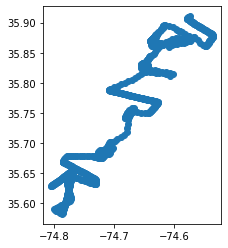

In [7]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [8]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [9]:
cdom_files = [
    'data/ivan_cruise/cdom/cdom_flu_output_210825_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210826_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210827_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210828_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210829_1.txt'
             ]

cdom_dfs = []

for item in cdom_files:
    cdom_data = open(item)
    lines = cdom_data.readlines()
    sensor_values = []
    utc_times = []
    for i in range(len(lines)):
        line = lines[i]
        if "sensor" in line:
            try:
                line = line.split('= ')[1]
                line = line.replace('\n', '')
                sensor_values.append(int(line))
                if "UTC" in lines[i-1]:
                    data_time = lines[i-1][5:-2]
                    utc_times.append(data_time)
                elif "UTC" in lines[i+1]:
                    data_time = lines[i+1][5:-2]
                    utc_times.append(data_time)
            except:
                pass
    print(len(sensor_values)-len(utc_times))
    sensor_values = sensor_values[len(sensor_values)-len(utc_times):]
    utc_times = pd.to_datetime(utc_times)
    cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])
    cdom_df['utc_dt'] = utc_times
    cdom_df  = cdom_df.set_index('utc_dt')
    cdom_dfs.append(cdom_df)
    
cdom_df = pd.DataFrame().append(cdom_dfs)

12
285
2
28
104


#### pull in the SST data from GOES

In [10]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#### Pull in the TriOS radiometer data

In [11]:
trios_fns = [
    'data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Based on our notes I believe that the TriOS data was saved as local time so I convert it here to UTC. I have not included the offset compared to the inline but that is likely about 10 seconds or more.

In [12]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

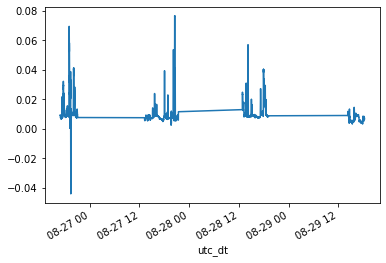

In [13]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [14]:
# these are the coefficients based on the Hu et al 2012 paper

ci1 = -0.49
ci2 = 191.6590

# these are some coefficients that I calculated using the same exact method but trying to optimize for the Micasense bands

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [15]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

Some of the values are way too high so cutting those off.

In [16]:
trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan

<ipython-input-16-07c79c7d9104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan


(0.0, 0.4)

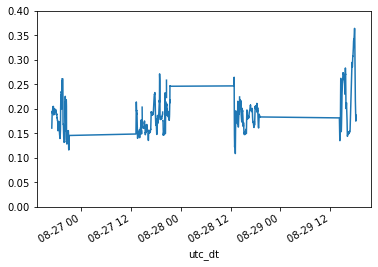

In [17]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

### Pull in HPLC timings

In [34]:
hplc_df = pd.read_csv('data/ivan_cruise/hplc_timing.csv')

In [35]:
hplc_df.head()

Sample  Date  Time (LST)  Volume (ml)                               Notes
0       1  26-8        1605          500          at the start of Ivan's dye
1       2  26-8        1605          500          at the start of Ivan's dye
2       3  26-8        1632          500         in the middle of the front?
3       4  27-8         742          500  starting transect on offshore side
4       5  27-8         811          500             in front - T&S changing

In [38]:
hplc_df['datetime'] = pd.to_datetime([datetime.strptime(x, '%Y %d-%m %H%M') for x in '2021 ' + hplc_df.Date + ' ' + hplc_df['Time (LST)'].astype(str)])
hplc_df['datetime']   = hplc_df['datetime'] + timedelta(hours=4) # moving it to UTC
hplc_df['utc_dt']   = hplc_df['datetime']
hplc_df = hplc_df.set_index('utc_dt')

## Visualizing the subset of transects with potentially good radiometer data

In [18]:
plt.rcParams.update({'font.size': 14})

In [54]:
len(hplc_df.loc[start_times[i]:end_times[i]])

2

In [66]:


hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)]

Sample  Date  Time (LST)  Volume (ml)  \
utc_dt                                                       
2021-08-29 16:30:00      24  29-8        1230          500   
2021-08-29 16:59:00      25  29-8        1259          500   
2021-08-29 17:39:00      26  29-8        1339          500   

                                                   Notes            datetime  
utc_dt                                                                        
2021-08-29 16:30:00          beginning of towyo transect 2021-08-29 16:30:00  
2021-08-29 16:59:00  in the middle of the front on towyo 2021-08-29 16:59:00  
2021-08-29 17:39:00            at end of front on towyo  2021-08-29 17:39:00

utc_dt
2021-08-27 16:07:00    11
2021-08-27 17:00:00    12
2021-08-27 17:33:00    13
Name: Sample, dtype: int64


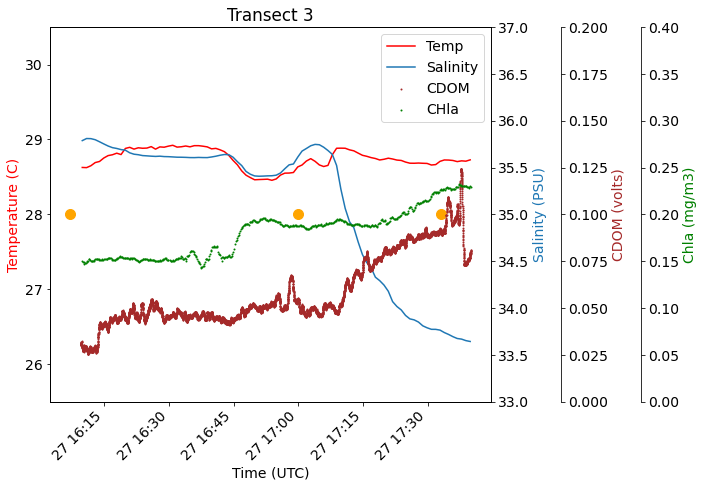

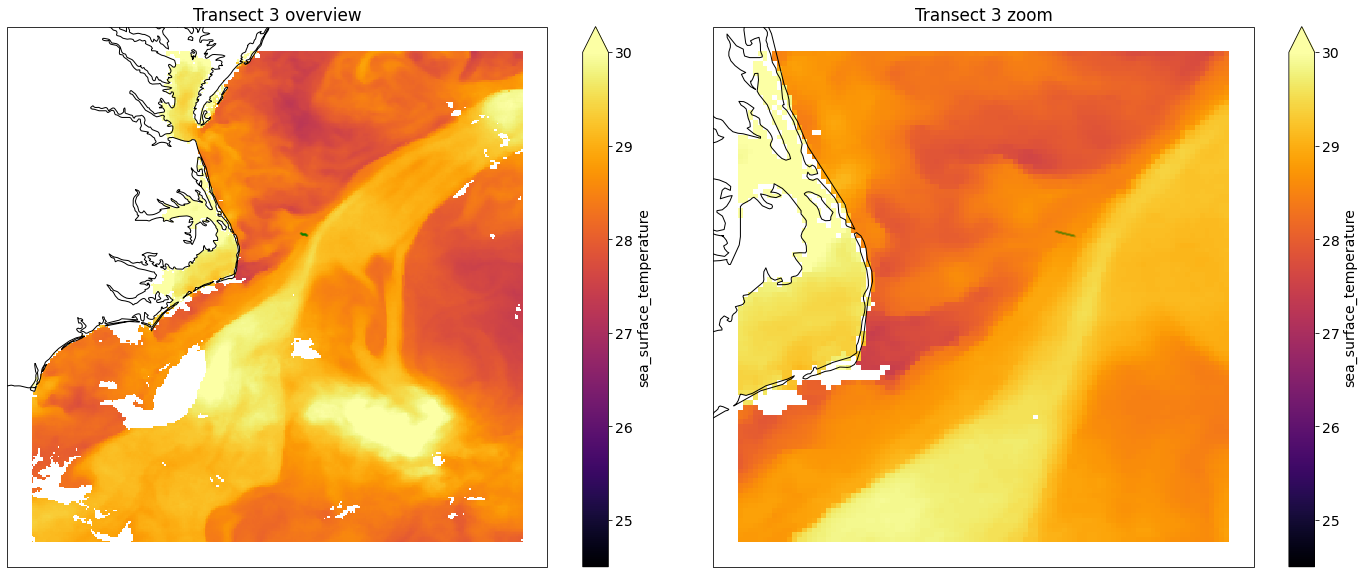

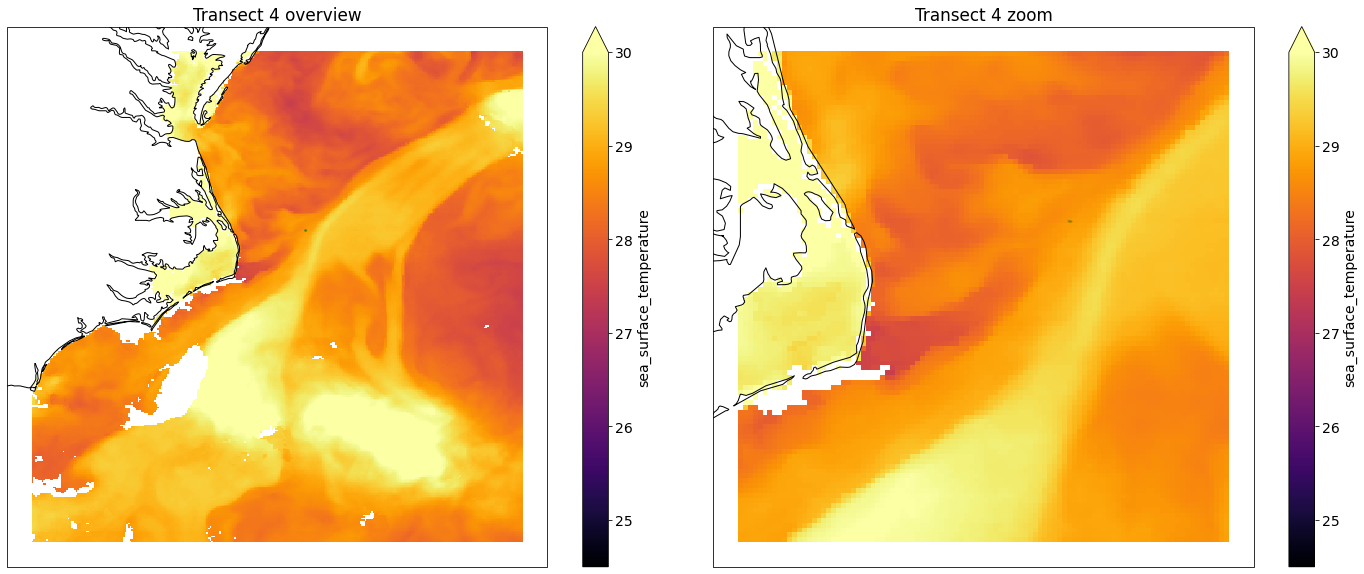

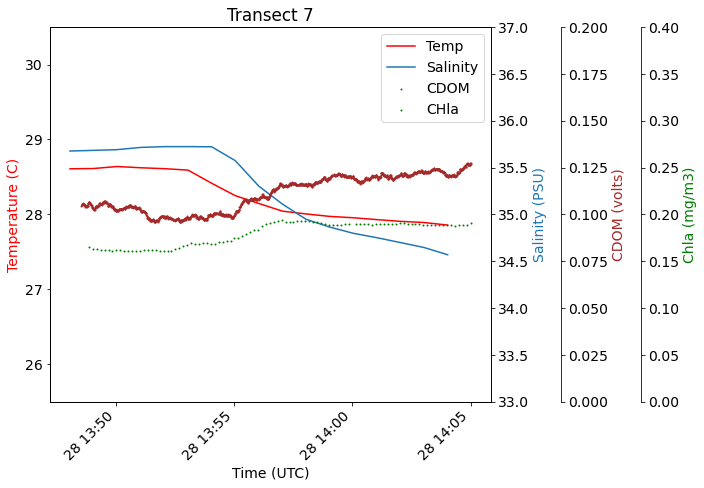

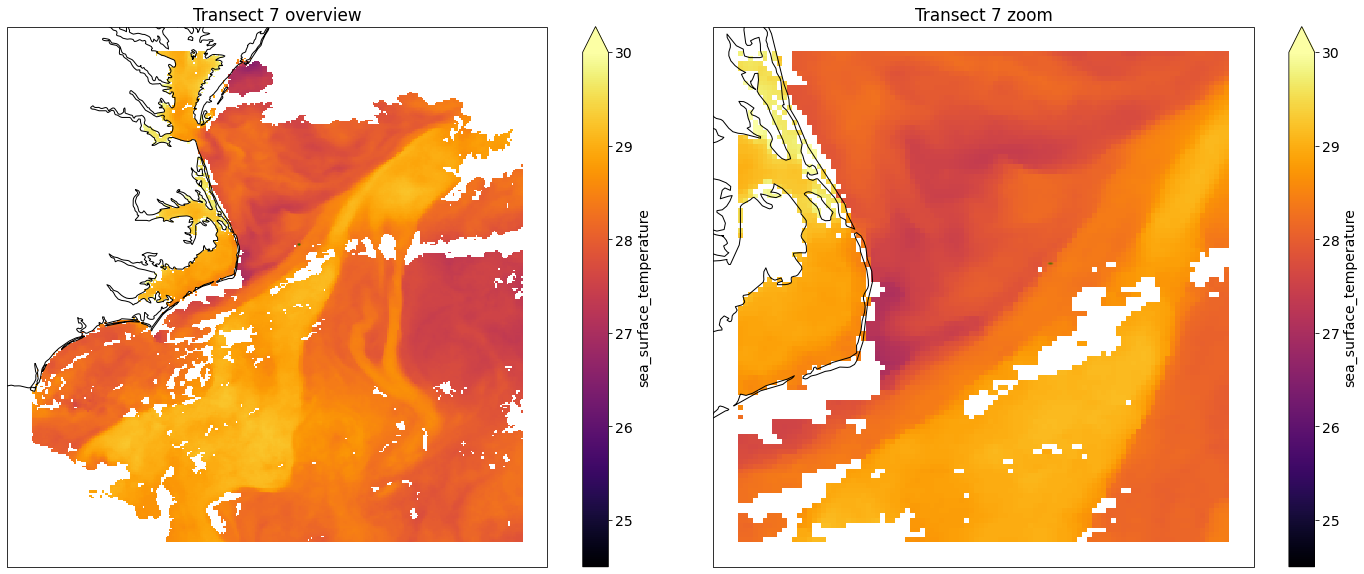

utc_dt
2021-08-28 15:16:00    17
2021-08-28 16:17:00    18
2021-08-28 16:47:00    19
Name: Sample, dtype: int64


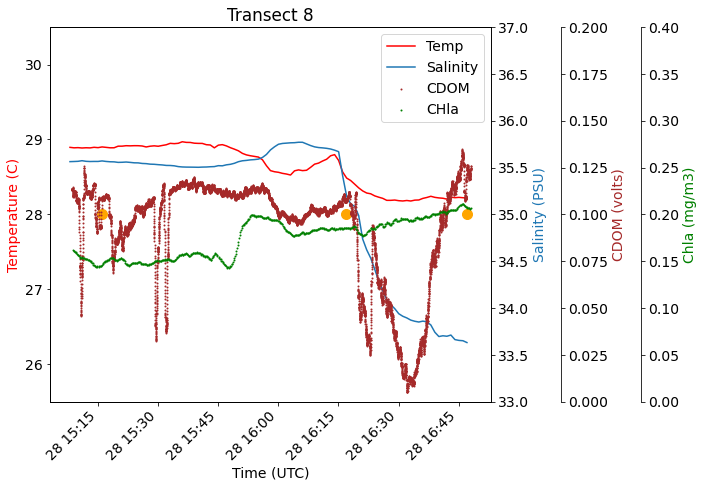

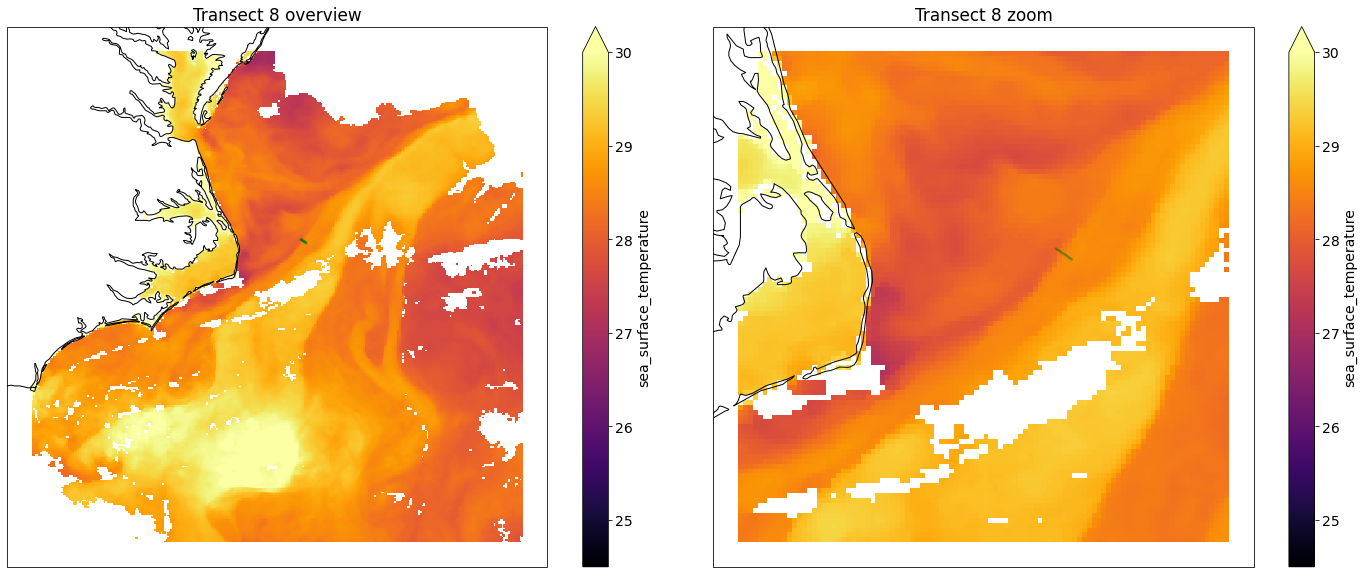

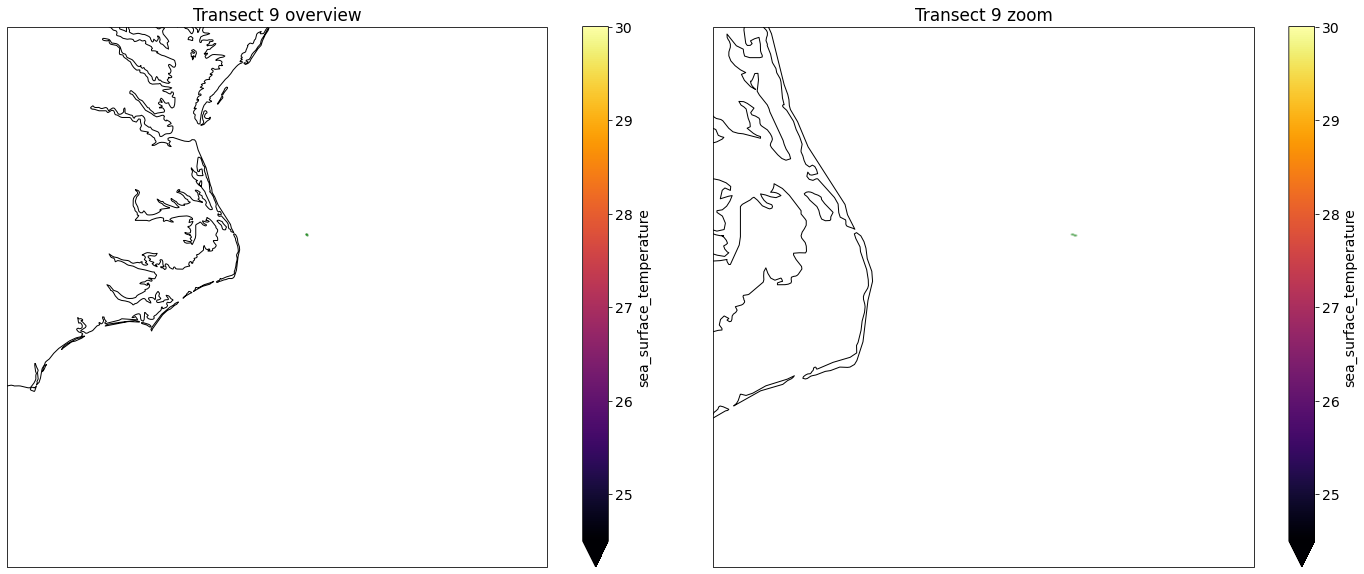

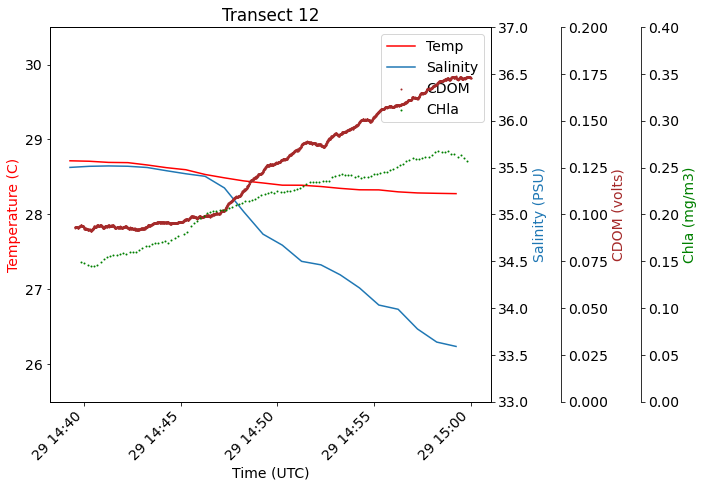

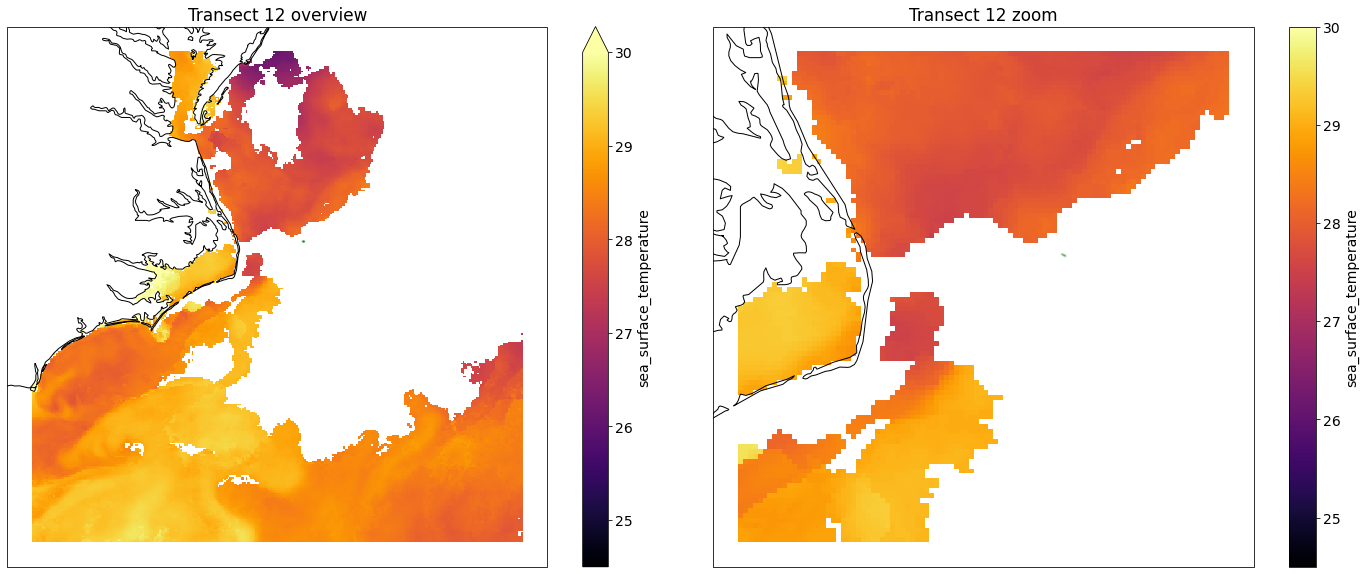

utc_dt
2021-08-29 16:30:00    24
2021-08-29 16:59:00    25
2021-08-29 17:39:00    26
Name: Sample, dtype: int64


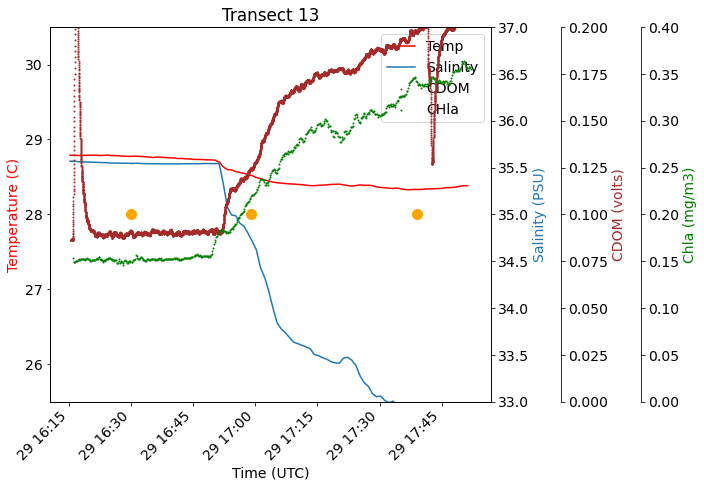

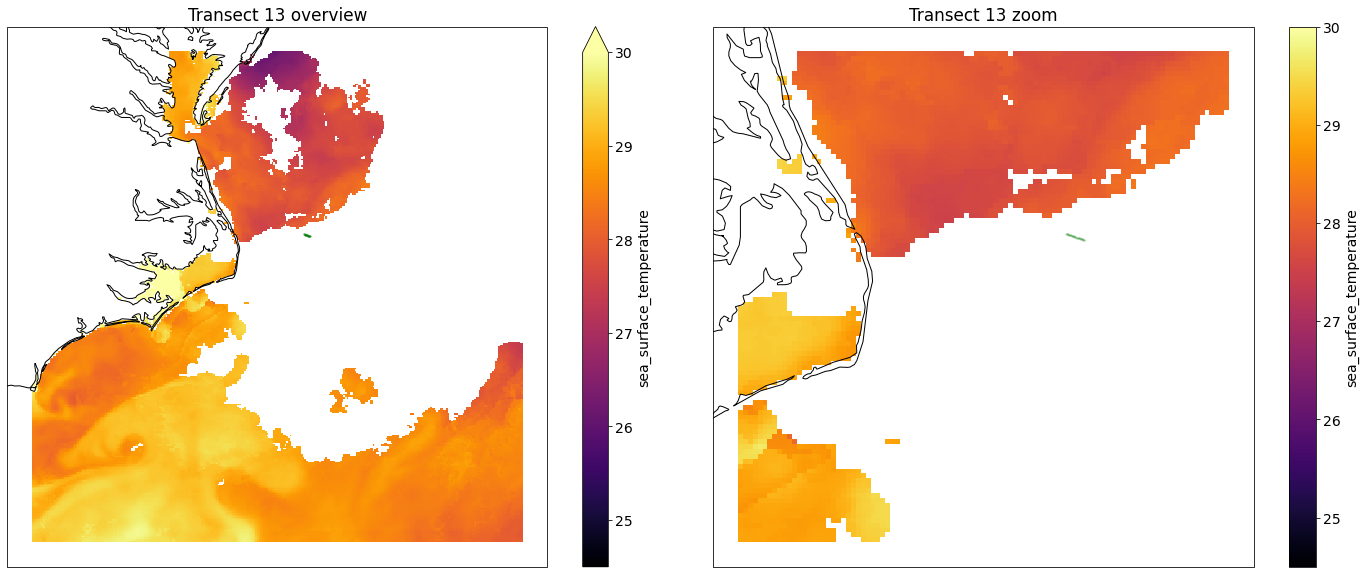

In [69]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        pass
    else:
        # time series plot
        fig, ax = plt.subplots(figsize=(10,7))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)
        ax2.set_ylim(.0, .20)
        ax3.set_ylim(.0, .40)

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Chla (mg/m3)")

        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)
        color3 = plt.cm.viridis(.9)

        p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
        p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
        
        hplc_df
        
        if hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
            hplc_data_x = None
            hplc_data_y = None
        else:
            hplc_data_x = hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].index, 
            hplc_data_y = [28]*len(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)])
            print(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].Sample)
        ax.scatter(hplc_data_x, hplc_data_y, color='orange', label='HPLC', s=100)
        
        if cdom_df.loc[start_times[i]:end_times[i]].rolling(window=6*10).mean()['cdom_volts'].empty:
            cdom_data_x = None
            cdom_data_y = None
        else:
            cdom_data_x = cdom_df.loc[start_times[i]:end_times[i]].index, 
            cdom_data_y = cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts']
        p3  = ax2.scatter(cdom_data_x, cdom_data_y, color='brown', label='CDOM', s=1)
        
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
        p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='CHla', s=1)

        ax.set_title(titles[i])


    #     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
    #     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
    #     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

        lns = [p1, p2, p3, p4]
        ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 70))

        ax3.spines['right'].set_position(('outward', 150))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
        ax3.yaxis.label.set_color('green')

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
        fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()



        # SST image

        fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
        ax[0].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)

        ax[1].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
        # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
        ax[0].set_title(titles[i] + ' overview')
        ax[1].set_title(titles[i] + ' zoom')
        fig.tight_layout()
    #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
    #     plt.close()
        plt.show()    

        # fig.savefig('transect' + str(i) '_s_t.png')

## Quantify uncertainty in the trios instrument on the SW

In this section I try to quantify uncertainty in the method by using a period where we didn't move much and then propogate that error to the chla measurement.

In [47]:
static_trios_df = trios_df.loc['2021-08-26 19:46:00':'2021-08-26 19:55:00']
len(static_trios_df)

55

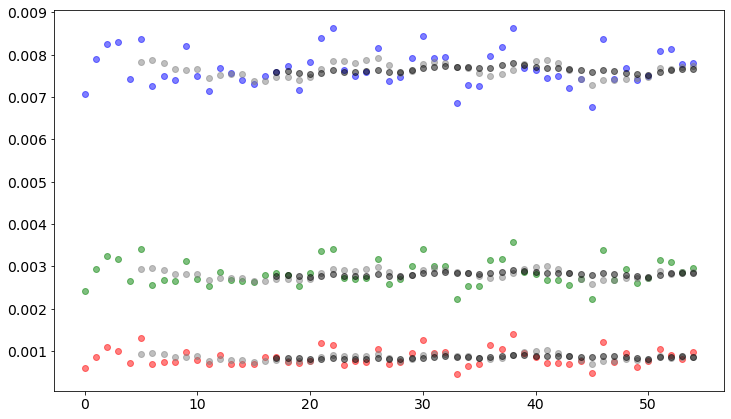

In [48]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:#,[232,240,'green'],[346,351,'red']]:
#     band_mean = static_trios_df.iloc[:, l:u].mean().mean()
#     band_std = static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1).std()
    
#     ax.axhline(band_mean,color=c)
#     ax.axhline(band_mean+band_std,color=c, ls='--')
#     ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='grey', alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=0.5)
    
# ax.set_ylim(-0.001,0.004)
plt.show()

Text(0.5, 0, 'Repeated measurement count')

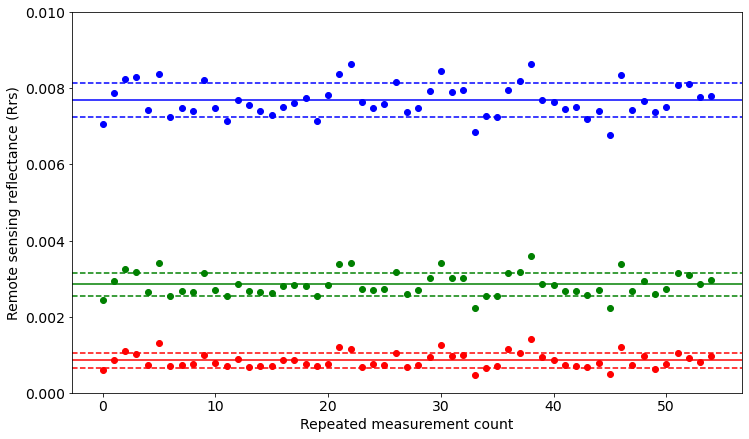

In [51]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    band_std = static_trios_df.iloc[:, l:u].mean(axis=1).std()
    
    
    ax.axhline(band_mean,color=c)
    ax.axhline(band_mean+band_std,color=c, ls='--')
    ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1)

ax.set_ylim(0,0.01)

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_trios.png',dpi=300)

Text(0.5, 0, 'Repeated measurement count')

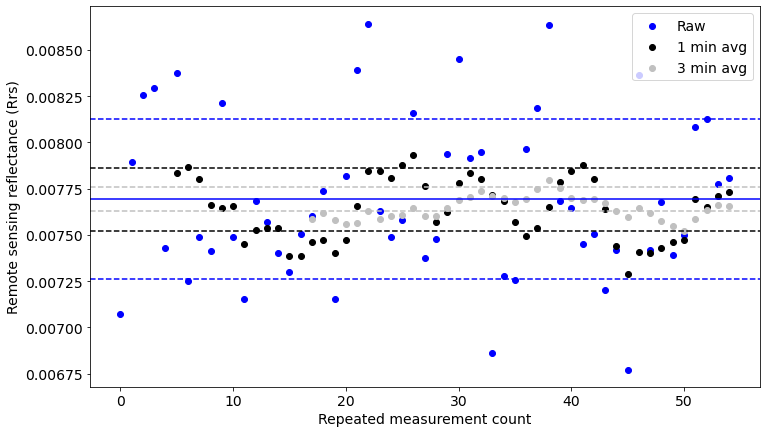

In [53]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    ax.axhline(band_mean,color=c)
    
    for i,c_std in [[1,'blue'],[6,'black'],[6*3,'silver']]:
        band_std = static_trios_df.rolling(window=i).mean().iloc[:, l:u].mean(axis=1).std()
        ax.axhline(band_mean+band_std,color=c_std, ls='--')
        ax.axhline(band_mean-band_std,color=c_std, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1, label='Raw')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1, label='1 min avg')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1, label='3 min avg')
ax.legend(loc='upper right')    
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_blue_avg.png',dpi=300)

You need the uncertainties package for this.

In [54]:
# pip install --upgrade uncertainties

In [55]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [56]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

In [57]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

Uncertainty based on the group of wavelengths used to calculate chla.

In [59]:
blue_uncert = np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.0004316484016933594, 0.0003025047880319788, 0.00020191965759646383)

Uncertainty based on a rolling window average of 6 measurements (1 minute)

In [306]:
blue_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.00016776638783025022, 0.00010788283891465276, 7.161309946806462e-05)

In [62]:
chla_uncerts = []

for i in range(len(trios_df)):
    blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
    green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
    red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)
    
    chla_u = oc_index(blue_u, green_u, red_u)
    
    chla_uncert = chla_u.s
    chla_uncerts.append(chla_uncert)

Example of calculating uncertainty

In [63]:
blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)

chla_u = oc_index(blue_u, green_u, red_u)

In [64]:
trios_df.iloc[i, 156:161].mean(), blue_uncert

(0.0075986914000000004, 0.0004316484016933594)

In [65]:
-260.43*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000167

-0.006779260494532654

In [66]:
(441.41*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000107)

0.007362084289281303

In [67]:
(-180.98*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.0000716)

-0.002019846872409247

In [68]:
import math
math.sqrt(0.0068**2+0.0074**2+0.002**2)

0.010246950765959599

In [69]:
blue_u, green_u, red_u

(0.0075986914000000004+/-0.0004316484016933594,
 0.004682888499999999+/-0.0003025047880319788,
 0.0030533482+/-0.00020191965759646383)

In [70]:
chla_u.error_components()

{0.0075986914000000004+/-0.0004316484016933594: 0.022862937692841537,
 0.0030533482+/-0.00020191965759646383: 0.007448298560927712,
 0.004682888499999999+/-0.0003025047880319788: 0.027181268898308585}

In [71]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [72]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [73]:
trios_df['chla_uncert'] = chla_uncerts

<ipython-input-74-779b19d7db1a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-74-779b19d7db1a>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-74-779b19d7db1a>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


Text(0.5, 0, 'Wavelength (nm)')

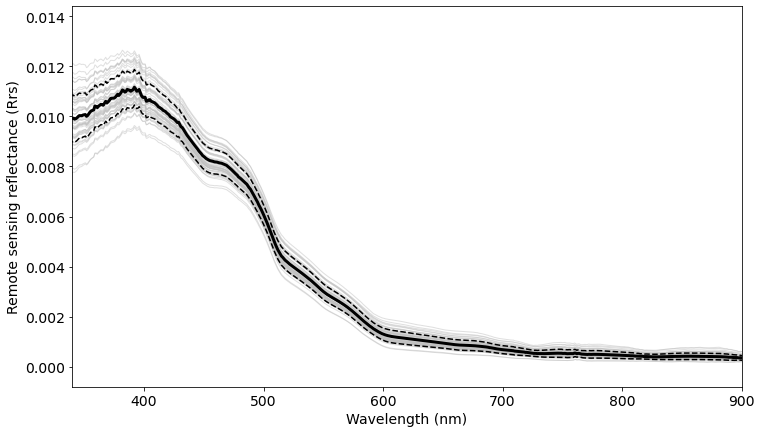

In [74]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2].values.T, color='silver', lw=1, alpha=0.5)
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('spectrum_repeated.png',dpi=300)

(340.0, 900.0)

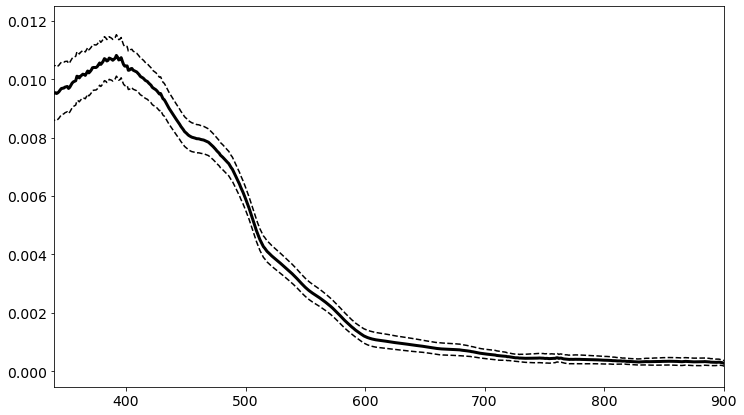

In [75]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2], color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


<ipython-input-76-f8aafffdfa3d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-76-f8aafffdfa3d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-76-f8aafffdfa3d>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


(340.0, 900.0)

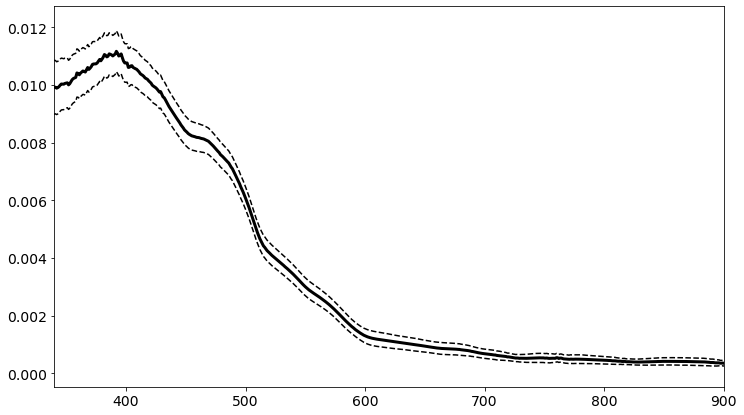

In [76]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


### Now look at this on a specific transect

In [78]:
transect = 2
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = trios_df.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]

Text(0.5, 1.0, '')

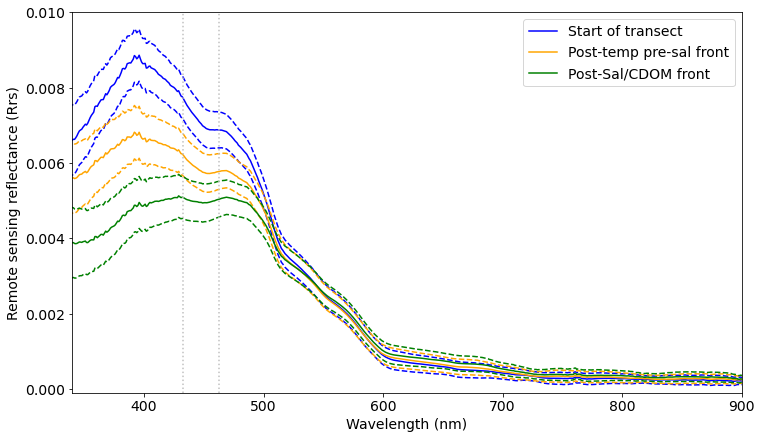

In [79]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')


# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)

ax.set_title('')


# plt.savefig('radiometry_spectra_across_front.png',dpi=300)


(-0.0001, 0.01)

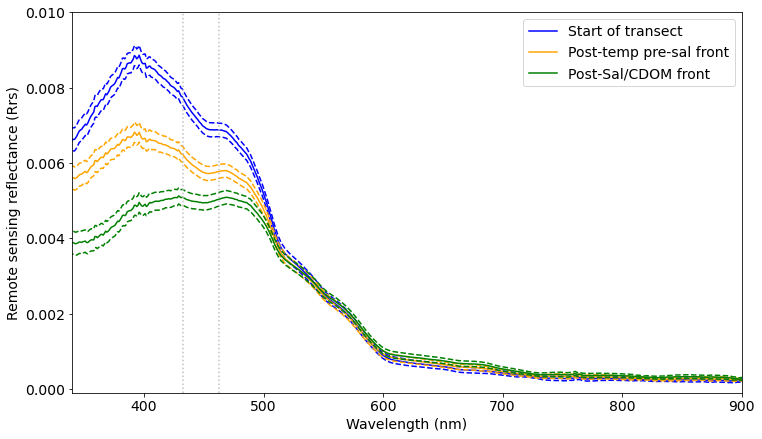

In [80]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')

# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)



# plt.savefig('radiometry_spectra_across_front_binned.png',dpi=300)


In [81]:
start_times[transect]

'2021-08-27 16:09:00'

In [82]:
end_times[transect]

'2021-08-27 17:40:00'

In [83]:
plt.rcParams.update({'font.size': 16})

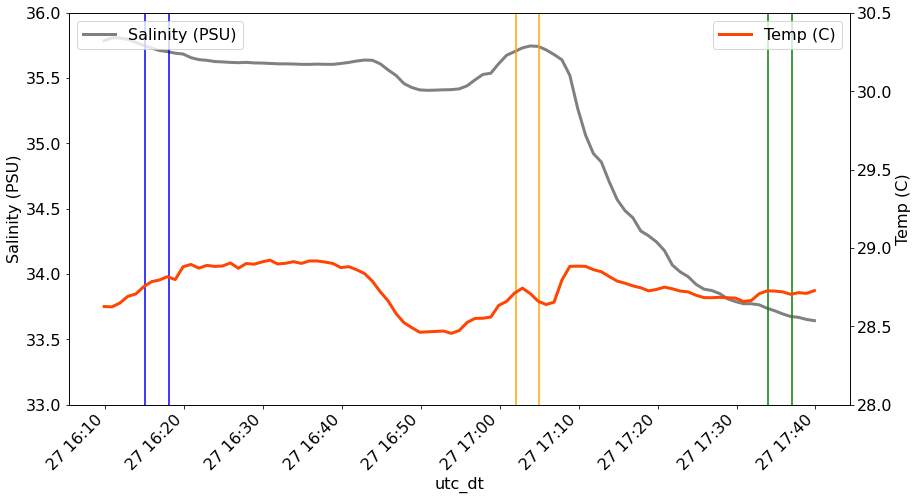

In [84]:
fig, ax = plt.subplots(figsize=(14,8))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax.axvline('2021-08-27 16:15:00',color='blue')
ax.axvline('2021-08-27 16:18:00',color='blue')

ax.axvline('2021-08-27 17:02:00',color='orange')
ax.axvline('2021-08-27 17:05:00',color='orange')

ax.axvline('2021-08-27 17:34:00',color='green')
ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_front.png')

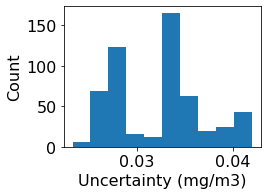

In [86]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(trios_df_transect['chla_uncert'])
ax.set_ylabel('Count')
ax.set_xlabel('Uncertainty (mg/m3)')
fig.tight_layout()
# fig.savefig('uncertanty_distribution.png',dpi=300)

In [87]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

The uncertainty is basically proportional to the chla

In [88]:
np.unique(trios_df_transect['chla_uncert']/trios_df_transect['chla_oci'])

array([0.17823885, 0.17823885, 0.17823885, 0.17823885])

In [325]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

In [89]:
trios_df_transect['chla_uncert']

utc_dt
2021-08-27 16:09:00    0.027039
2021-08-27 16:09:10    0.027338
2021-08-27 16:09:20    0.026979
2021-08-27 16:09:30    0.026217
2021-08-27 16:09:40    0.026564
                         ...   
2021-08-27 17:39:20    0.041426
2021-08-27 17:39:30    0.040494
2021-08-27 17:39:40    0.041597
2021-08-27 17:39:50    0.041978
2021-08-27 17:40:00    0.039491
Name: chla_uncert, Length: 541, dtype: float64

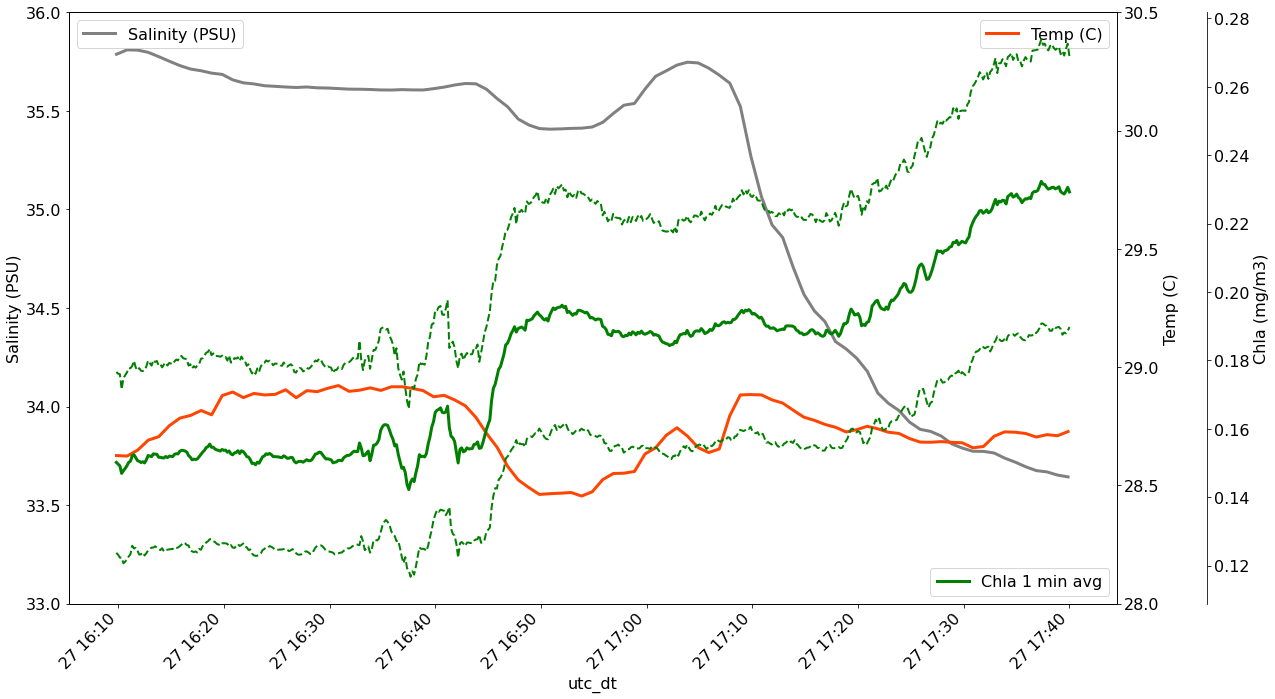

In [90]:
fig, ax = plt.subplots(figsize=(18,10))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax2 = ax.twinx()

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax2, color='green', label='Chla 1 min avg', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')

# ax.axvline('2021-08-27 16:15:00',color='blue')
# ax.axvline('2021-08-27 16:18:00',color='blue')

# ax.axvline('2021-08-27 17:02:00',color='orange')
# ax.axvline('2021-08-27 17:05:00',color='orange')

# ax.axvline('2021-08-27 17:34:00',color='green')
# ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')
ax2.set_ylabel('Chla (mg/m3)')

ax2.spines['right'].set_position(('outward', 90))

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
# fig.savefig('chla_uncert_sal_temp.png')

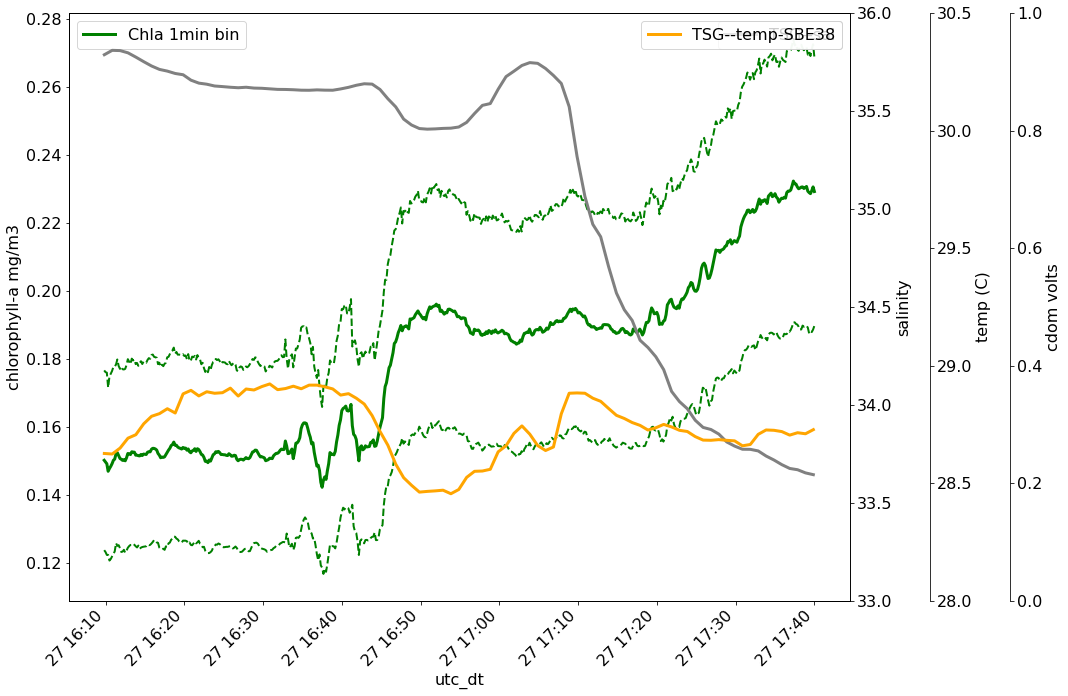

In [91]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

ax3.spines['right'].set_position(('outward', 80))
ax4.spines['right'].set_position(('outward', 160))


df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3, color='grey')
ax2.set_ylim(33,36)

df_transect.plot(y='TSG--temp-SBE38',ax=ax3, linewidth=3, color='orange')
ax3.set_ylim(28,30.5)

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('salinity')
ax3.set_ylabel('temp (C)')
ax4.set_ylabel('cdom volts')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('chla_uncert_sal_temp.png')

### Explore the radiometer data a bit more

Checking out and clustering a transect

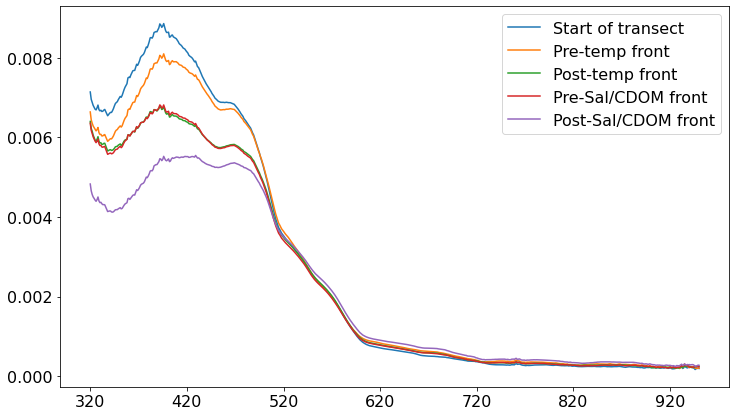

In [92]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [96]:
lats = []
lons = []
for i in range(len(trios_df)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(trios_df.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)

In [97]:
trios_df['lat'] = lats
trios_df['lon'] = lons

In [98]:
trios_gdf = gpd.GeoDataFrame(
    trios_df, geometry=gpd.points_from_xy(trios_df.lon, trios_df.lat))

<AxesSubplot:>

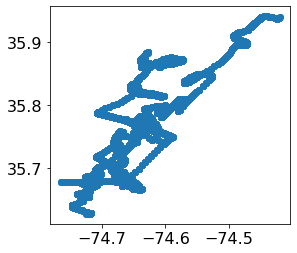

In [99]:
trios_gdf.plot()

In [100]:
trios_gdf.columns

Index(['TimeStamp', '320', '321', '322', '323', '324', '325', '326', '327',
       '328',
       ...
       '947', '948', '949', '950', 'datetime', 'chla_oci', 'chla_uncert',
       'lat', 'lon', 'geometry'],
      dtype='object', length=638)

array([0.14986529, 0.14638241, 0.1477637 , ..., 0.19077348, 0.19532731,
       0.20360694])

In [103]:
chlci = trios_gdf.chla_oci.values

In [104]:
chlci[chlci>.5] = .5

(0.1, 0.32)

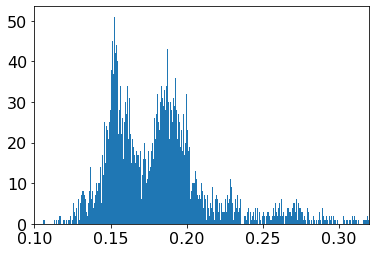

In [105]:
plt.hist(chlci, bins=2000)
plt.xlim(0.1,.32)

In [106]:
trios_gdf.iloc[:, 156:161].mean(axis=1).values

array([0.00679766, 0.00649958, 0.00647011, ..., 0.00542037, 0.00630935,
       0.00759869])

In [107]:
trios_gdf.iloc[:, 232:240].mean(axis=1).values

array([0.00260392, 0.00223146, 0.00225324, ..., 0.0019946 , 0.00309086,
       0.00468289])

In [108]:
trios_gdf.iloc[:, 346:351].mean(axis=1).values

array([ 8.3092520e-04,  4.8145580e-04,  5.2497140e-04, ...,
       -7.8520240e-06,  1.2558356e-03,  3.0533482e-03])

In [112]:
trios_gdf.columns[1:-6]

Index(['320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
       ...
       '941', '942', '943', '944', '945', '946', '947', '948', '949', '950'],
      dtype='object', length=631)

Run some clustering

In [113]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(trios_gdf.values[:,1:-6])

In [115]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([7116,    3,   23,    5,  114,    5,    5,   42,    4,  219,    5,
          69,    7,    3,  525]))

Text(0.5, 1.0, 'August 27th Trios Radiometer based Chla')

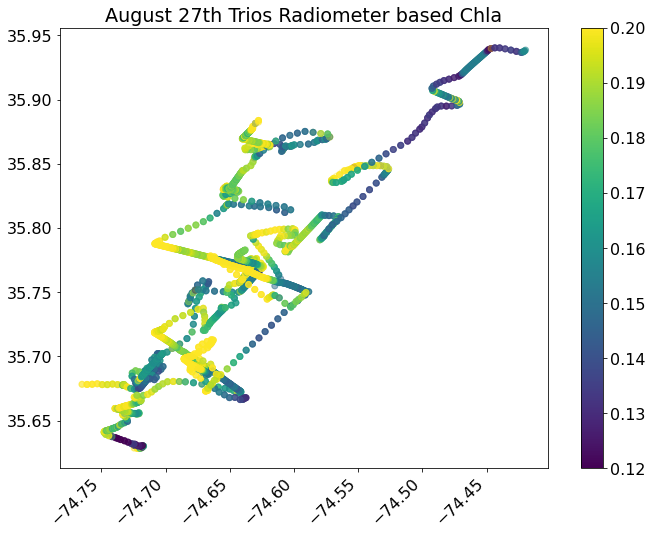

In [116]:
fig, ax = plt.subplots(figsize=(12,9))
sc = trios_gdf.plot('chla_oci', ax=ax, vmin=.12,vmax=.20, cmap='viridis', alpha=0.3, label='CI Chla', legend=True)
# ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
# fig.colorbar(sc,ax=ax)
# fig.colorbar(sc, ax=ax)
fig.autofmt_xdate(rotation=45)
ax.set_title('August 27th Trios Radiometer based Chla')
# fig.savefig('trios_radiometers_chlaci.png')

In [117]:
fig, ax = plt.subplots(figsize=(8,6))
trios_gdf.plot(c=kmeans.labels_,ax=ax)

<AxesSubplot:>

In [118]:
trios_gdf_transect = trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [119]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-6]

In [120]:
x = x[12:,:]

In [121]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [122]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [123]:
principalComponents.shape

(433, 2)

In [125]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chla_oci,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)
# fig.savefig('chla_transect.png')

<AxesSubplot:>

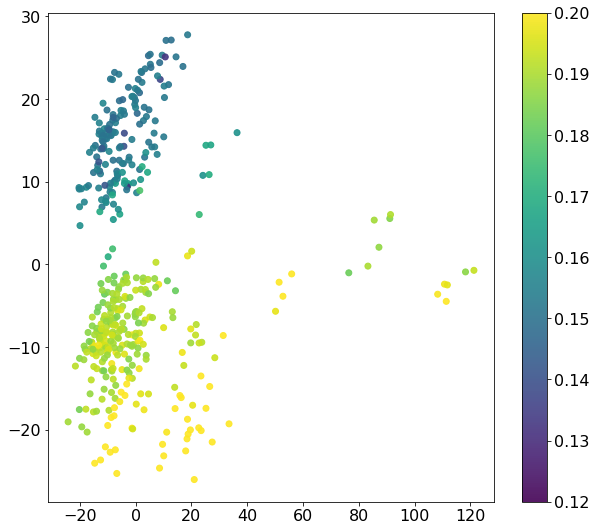

In [127]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [128]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 55, 210,  12,  44, 112]))

In [129]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=kmeans.labels_,ax=ax, alpha=0.2)

<AxesSubplot:>

In [130]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),trios_gdf_transect.chla_oci.iloc[12:].rolling(window=12).mean())
ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_, alpha=0.2, c=kmeans.labels_)
# fig.savefig('cluster_chla.png')